In [3]:

import numpy as np 
import pandas as pd 


In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [27]:
X = train.drop('label',axis=1)
y = train['label']

### Convert dataframe to numpy arrays
-1: keep number of row the same <br>
28, 28: height, width <br>
1: grayscale

In [28]:
X = X.values.reshape(-1, 28, 28, 1) 
y = y.values

### Create the model using TensorFlow Keras

In [9]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

num_classes = 10

input_shape = (28, 28, 1)


# create convolution model using tensorflow keras
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

### Train the model

In [10]:
# Train the model

batch_size = 128
epochs = 40


hist = model.fit(X, y, validation_split=0.1, batch_size=batch_size, epochs=epochs, verbose=0)
print("The model has successfully trained")

model.save('mnist.h5')
print("Saving the model as mnist.h5")

The model has successfully trained
Saving the model as mnist.h5


In [11]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Visualize the model accuracy and loss

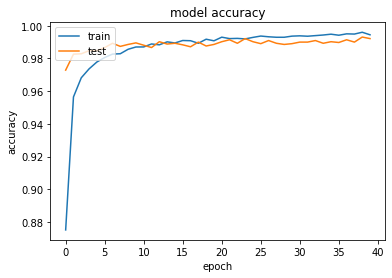

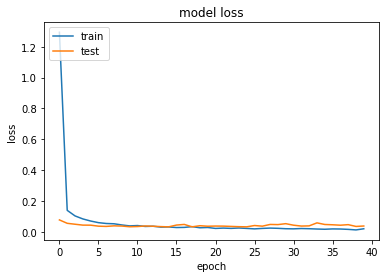

In [13]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# get accuracy and loss
score = model.evaluate(X, y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0052346037700772285
Test accuracy: 0.9989047646522522


### Accuracy looks good. Now we will use the model on test data

In [ ]:
# get test data and reformat it
test = test.values.reshape(-1,28,28,1)

In [ ]:
# make predictions on the test dataset
predictions = model.predict(test)
results = predictions.argmax(axis=-1)


In [ ]:
# create output dataframe and generate ImageID based on size of result set
output = pd.DataFrame()
output['ImageId'] = range(1, len(results) + 1)

In [ ]:
# export predictiosn to output fil
output['Label'] = results
output.to_csv("output.csv", index = False)
print ("Output file saved.")

In [50]:
from keras.models import load_model
from tkinter import *
import tkinter as tk
import win32gui
from PIL import ImageGrab, Image
import numpy as np
model = load_model('mnist.h5')


def predict_digit(img):
    #resize image to 28x28 pixels
    img = img.resize((28,28))
    #convert rgb to grayscale
    img = img.convert('L')
    img = np.array(img)
    
    #reshaping to support our model input and normalizing
    #print (np.rint(-((img/255.0) - 1)*10)*25)
    img = (np.rint(-((img/255.0) - 1)*10)*25)
    img = img.reshape(1,28,28,-1)
    # img/255.0
    #print (img)
    
    #predicting the class
    test = model.predict(img)
    test2 = test.argmax(axis=-1)
    res = model.predict(img)[0]
    #print (test2)
    return np.argmax(res), max(res)


class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        # Creating elements
        self.canvas = tk.Canvas(self, width=300, height=300, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.classify_btn = tk.Button(self, text = "Recognise", command = self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.classify_btn.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        
        self.canvas.bind("<B1-Motion>", self.draw_lines)
        
    def clear_all(self):
        self.canvas.delete("all")
        
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        im = ImageGrab.grab(rect)
       
        digit, acc = predict_digit(im)
        self.label.configure(text= str(digit)+', '+ str(int(acc*100))+'%')
        
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=8
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')
        
app = App()
mainloop()